# Independent set benchmarking

In this notebook we look at solving the independent set instance with 52 variables contained in aves-sparrow-social.gph.

In [1]:
from collections import defaultdict
from time import time
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

from qiskit.transpiler import CouplingMap
from qiskit.transpiler.passes.routing.commuting_2q_gate_routing import SwapStrategy

from qiskit_ibm_runtime import QiskitRuntimeService, Session, Sampler

from qiskit_optimization.applications import StableSet
from qiskit_optimization.algorithms import CplexOptimizer
from qiskit_optimization.converters import QuadraticProgramToQubo

from independent_set_benchmarking.analysis import counts_to_cost_val, to_cdf, random_sampling, average_results
from independent_set_benchmarking.utils import load_graph, save_hardware_result
from independent_set_benchmarking.transpile import circuit_construction, swap_strategy_simplify
from independent_set_benchmarking.post_process import greedy_post_process
from independent_set_benchmarking.optimization import optimize_lambda, plot_lambda_optimization

### Load the graph

In [2]:
file_name = "aves-sparrow-social.gph"

graph, original_graph = load_graph(f"../instances/{file_name}")

In [3]:
print("Number of edges in the graph:", len(graph.edges))

Number of edges in the graph: 454


We define a SWAP strategy to implement the graph on hardware.

In [4]:
swap_strat = SwapStrategy.from_line(range(graph.order()))
edge_coloring = {(idx, idx + 1): (idx + 1) % 2 for idx in range(graph.order())}

Since the full instance requires too many gates we compute simplified instances where we remove edges from the graph based on what can easily be done on hardware.

In [5]:
start = time()
sub_graphs = swap_strategy_simplify(swap_strat, graph)
print(f"Pre processing time {time() - start:.2f} seconds.")

Pre processing time 0.06 seconds.


## Create the QUBO for QAOA and optimize the parameters

The lagrange multiplier is chosen based on an optimization that balences objective and constraints.

In [6]:
num_layers = 3
sub_instance = StableSet(sub_graphs[num_layers])

start = time()
lambdas_scan = [0.001, 0.05, 0.1, 0.15, 0.2]
results = optimize_lambda(graph, lambdas_scan, ansatz_sub_graph=sub_graphs[num_layers])
print(f"Time taken to optimize lambda, beta, gamma for {num_layers} swap layers: {time() - start} seconds")

Time taken to optimize lambda, beta, gamma for 3 swap layers: 221.28162574768066 seconds


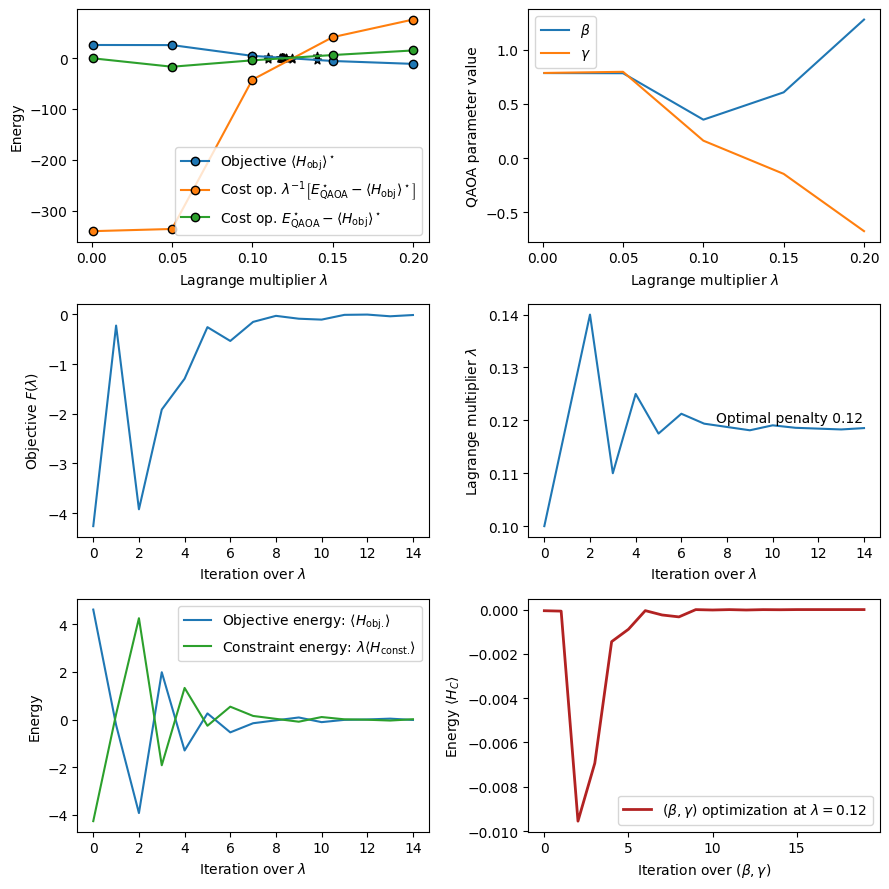

In [6]:
fig, axs = plot_lambda_optimization(results, lambdas_scan)

In [8]:
# Set the chosen Lagrange multiplier
chosen_lambda = float(results["scipy"]["history"][-1][1])
p = [results["scipy"]["all_results"][-1]["optimized_params"]]

# Use this if the lambda_optimization was not run
# chosen_lambda = 0.1185375
# p = [[0.4332228108246358, -0.00044486636226256075]]

In [8]:
fig.savefig("../plots/sparrow_lambda_optimization.pdf", bbox_inches="tight")

### Circuit construction

Construct the circuits. This will construct several circuits corresponding to different stages of the circuit construction pipeline

In [9]:
# service = QiskitRuntimeService(instance="...")
# backend = service.backend("ibm_fez", use_fractional_gates=False)

backend = None

In [12]:
start = time()

instance = StableSet(graph)
qp = instance.to_quadratic_program()

sub_instance = StableSet(sub_graphs[num_layers])
sub_qp = sub_instance.to_quadratic_program()

qubo = QuadraticProgramToQubo(penalty=chosen_lambda).convert(qp)
cost_op, offset = qubo.to_ising()
cost_op = -cost_op
offset = -offset

# Operators for Ansatz construction
sub_op, _ = QuadraticProgramToQubo(penalty=chosen_lambda).convert(sub_qp).to_ising()
sub_op = -sub_op
singles = sub_op[sub_op.paulis.z.sum(axis=-1) == 1]
doubles = sub_op[sub_op.paulis.z.sum(axis=-1) == 2]
metadata = {"number swap layers": num_layers, "penalty": chosen_lambda}

all_circuits = circuit_construction(
    singles, doubles, p[0], backend, swap_strat, edge_coloring, metadata
)

circ_construction_time = time() - start
print(f"Circuit construction time is {circ_construction_time} seconds.")

Circuit construction time is 0.411820650100708 seconds.


In [13]:
len(doubles)

76

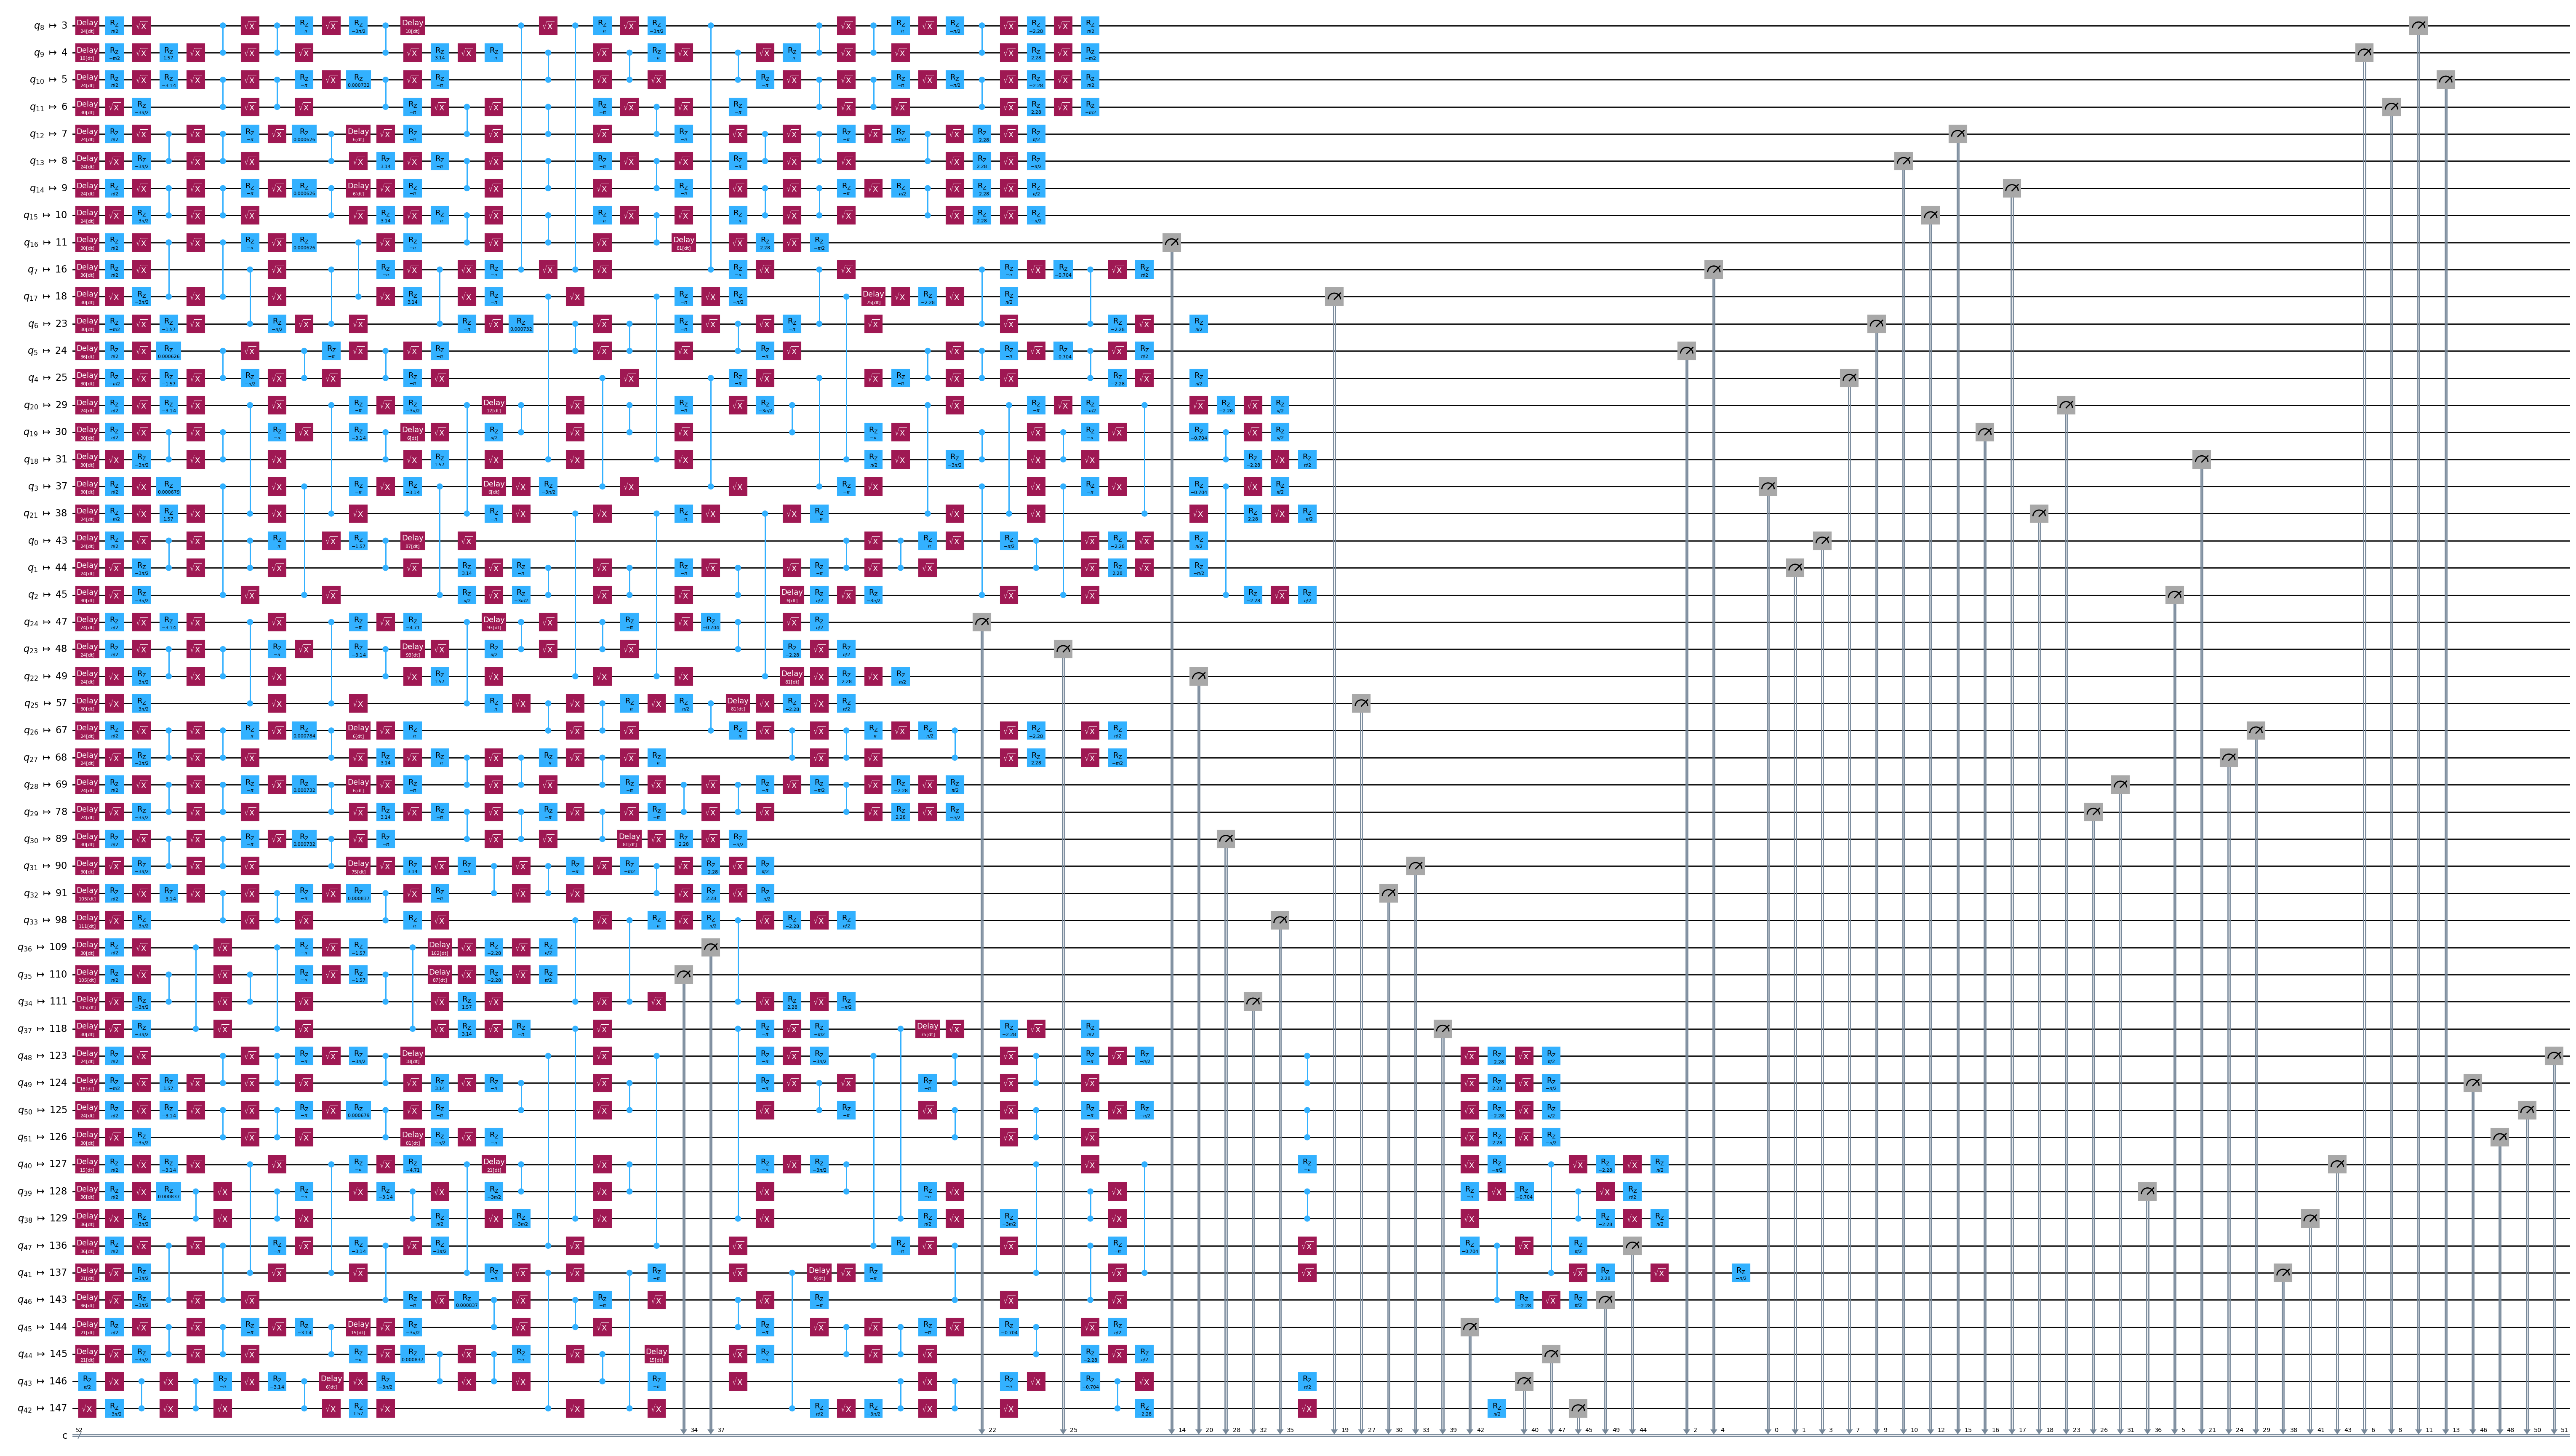

In [12]:
all_circuits["backend"].draw("mpl", fold=False, idle_wires=False)

In [13]:
all_circuits["backend"].count_ops()["cz"]

207

#### Get baseline with CPLEX

In [14]:
start = time()
cplex_res = CplexOptimizer().solve(qp)
print("CPLEX time: ", time() - start, "seconds")
cplex_res

CPLEX time:  0.2436046600341797 seconds


<OptimizationResult: fval=13.0, x_0=1.0, x_1=0.0, x_2=0.0, x_3=0.0, x_4=0.0, x_5=0.0, x_6=0.0, x_7=0.0, x_8=0.0, x_9=0.0, x_10=0.0, x_11=0.0, x_12=0.0, x_13=0.0, x_14=0.0, x_15=0.0, x_16=0.0, x_17=1.0, x_18=0.0, x_19=1.0, x_20=0.0, x_21=0.0, x_22=0.0, x_23=0.0, x_24=0.0, x_25=0.0, x_26=0.0, x_27=1.0, x_28=0.0, x_29=0.0, x_30=0.0, x_31=0.0, x_32=0.0, x_33=0.0, x_34=1.0, x_35=0.0, x_36=0.0, x_37=1.0, x_38=1.0, x_39=1.0, x_40=0.0, x_41=1.0, x_42=0.0, x_43=1.0, x_44=0.0, x_45=0.0, x_46=0.0, x_47=1.0, x_48=1.0, x_49=0.0, x_50=1.0, x_51=0.0, status=SUCCESS>

### Random sampling for the benchmark

We will compare hardware results to random sampling.

In [15]:
rand_alls, rand_all_cost_vals, rand_all_infs = [], [], []

for _ in range(5):
    rand_cost_vals, rand_inf, rand_samples = random_sampling(1024, graph)
    rand_alls.append({key: rand_inf.get(key, 0) + rand_cost_vals.get(key, 0)  for key in set(rand_inf.keys()) | set(rand_cost_vals.keys())})
    rand_all_cost_vals.append(rand_cost_vals)
    rand_all_infs.append(rand_inf)

## Execute on hardware

We execute the quantum circuit with the trained parameters on *ibm_fez*; an IBM Quantum superconducting qubit based device with a controlled-phase gate as a two-qubit gate.

In [17]:
sampler_jobs = []

for _ in range(5):
    with Session(backend=backend) as session:
        samplerb = Sampler(mode=session)
        sampler_job = samplerb.run([all_circuits["backend"]], shots=1024)
        sampler_jobs.append(sampler_job)

In [18]:
all_circuits["backend"].metadata

{'number swap layers': 3,
 'penalty': 0.11853750000000002,
 'parameters': [0.4332228108246358, -0.00044486636226256075]}

In [19]:
for sampler_job in sampler_jobs:
    print(sampler_job.job_id())

cydm2na9b62g008jfymg
cydm2ptrta1g0087z9yg
cydm2qtnrmz00086dx60
cydm2rv9b62g008jfypg
cydm2svcw2k0008kr9pg


Load the job to be able to analyze its results.

In [20]:
sampler_jobs, fez_results = [], []
save = False

for idx, job_id in enumerate(["cy388wbrta1g0086tdw0", "cy388xb01rbg008hxge0", "cy388y39b62g008havz0", "cy388z3nrmz000858vy0", "cy388zvnrmz000858vyg"]):
    sampler_job = service.job(job_id)
    sampler_jobs.append(sampler_job)

    if save:
        save_hardware_result(sampler_job, f"sparrow_final{idx}")

    fez_results.append(sampler_job.result())

In [21]:
num_swaps = fez_results[0][0].metadata["circuit_metadata"]["number swap layers"]

In [ ]:
fez_counts = [res[0].data.c.get_counts() for res in fez_results]

In [22]:
fez_cost_vals, fez_infeasibles, fez_all = [], [], []

for res in fez_results:
    cv, inf = counts_to_cost_val(graph, res[0].data.c.get_counts())
    fez_cost_vals.append(cv)
    fez_infeasibles.append(inf)

    fez_all.append({key: inf.get(key, 0) + cv.get(key, 0)  for key in set(inf.keys()) | set(cv.keys())})

## Load results

This only needs to be done if we did not execute on hardware and want to re-load existing data.

In [16]:
import glob
import json

In [18]:
job_ids = ["cy388wbrta1g0086tdw0", "cy388xb01rbg008hxge0", "cy388y39b62g008havz0", "cy388z3nrmz000858vy0", "cy388zvnrmz000858vyg"]

fez_cost_vals, fez_infeasibles, fez_all, fez_counts = [], [], [], []

for job_id in job_ids:
    counts = None
    for file in glob.glob("../results_hardware/*.json"):
        if job_id in file and "metrics" not in file:
            with open(file, "r") as fin:
                data = json.load(fin)
            counts = data[0][-1]

    fez_counts.append(counts)
    cv, inf = counts_to_cost_val(graph, counts)
    fez_cost_vals.append(cv)
    fez_infeasibles.append(inf)

    fez_all.append({key: inf.get(key, 0) + cv.get(key, 0)  for key in set(inf.keys()) | set(cv.keys())})

## Result plotting

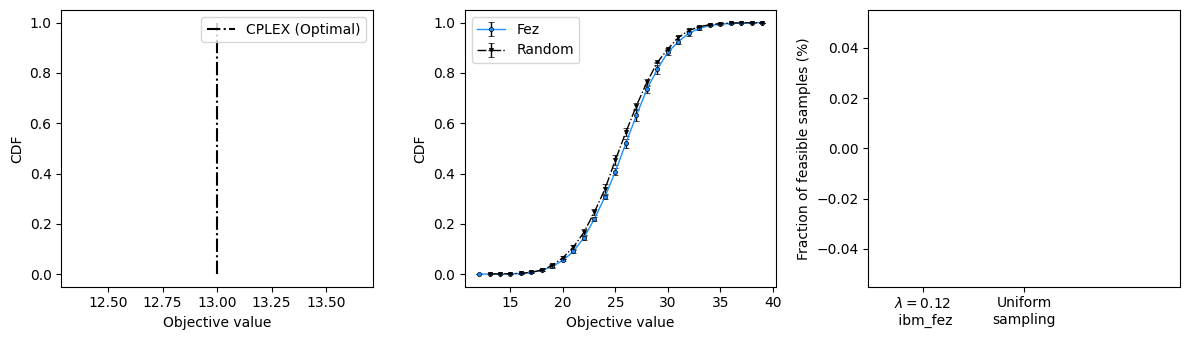

In [31]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3.5))

nff, nfi = sum(rand_cost_vals.values()), sum(rand_inf.values())
axs[2].bar([2], [100*nff / (nff + nfi)], color="k")

opts = {"lw": 1, "color": "dodgerblue", "ms": 3, "marker": "o", "ecolor": "k", "elinewidth": 1, "capsize": 2, "mec": "k", "mew": 0.5}
opts["label"] = "Fez"
data = average_results(fez_cost_vals, opts)
if len(data["x"]) > 0:
    axs[0].errorbar(**data)
axs[1].errorbar(**average_results(fez_all, opts))

for idx, vals in enumerate([(fez_cost_vals, fez_infeasibles), (rand_all_cost_vals, rand_all_infs)]):
    feasible = []
    for jidx, val in enumerate(vals[0]):
        feasible.append(sum(val.values()) / (sum(val.values()) + sum(vals[1][jidx].values())))

    axs[2].bar([idx], 100 * np.average(feasible), color="dodgerblue", alpha=0.5)

for ax in axs[0:2]:
    ax.set_xlabel("Objective value")
    ax.set_ylabel("CDF")

axs[1].legend()
axs[2].set_xticks(range(2))
axs[2].set_xticklabels([f"$\lambda={chosen_lambda:.2f}$\n ibm_fez", "Uniform\nsampling"])
axs[2].set_ylabel("Fraction of feasible samples (%)")
axs[0].vlines(cplex_res.fval, 0, 1, color="k", ls="-.", label="CPLEX (Optimal)")
axs[0].legend()
fig.tight_layout()
# fig.savefig("../plots/sparrow_samples.pdf", bbox_inches="tight")

opts.update({"marker": "v", "color": "k", "ls": "-.", "label": "Random"})
axs[1].errorbar(**average_results(rand_alls, opts))
axs[1].legend()

### Problem specific post-processing

Here we run through the following post processing.

**Step 1: Enforce feasibility**

* For every selected node, determine the number of violated constraints (= number of edges that point back to the selected subset of nodes).
* Sort by number of violations.
* Remove the node with the largest number of violations and update the number of violations for the remaining nodes
* Repeat until all violations have been resolved

**Step 2: Improve solution while staying feasible**

* For all not selected nodes, determine whether adding them to the set would violate the constraints.
* Start adding nodes to the solution in some order and update which ones are feasible (= remove all neighbors of nodes that have been added). As a rule of thumb one could pick the nodes sorted by their degree and prefer nodes that have a small number of edges or just randomly pick from the feasible ones.

In [32]:
rand_counts = defaultdict(float)
for sample in rand_samples:
    rand_counts["".join([str(val) for val in sample[::-1]])] += 1

Post processing time 1.9667110919952393 +- 0.01905444362700422 seconds


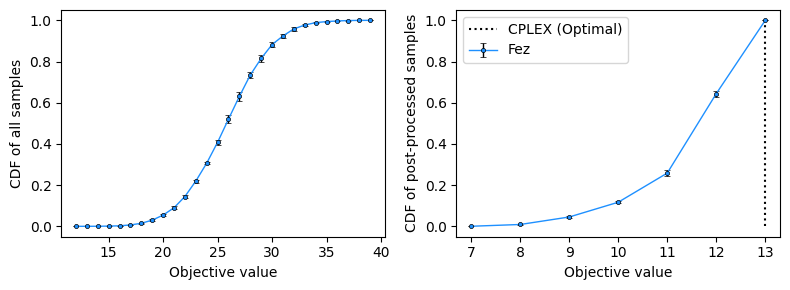

In [34]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3))

opts = {"lw": 1, "color": "dodgerblue", "ms": 3, "marker": "o", "ecolor": "k", "elinewidth": 1, "capsize": 2, "mec": "k", "mew": 0.5}
opts["label"] = "Fez"
axs[0].errorbar(**average_results(fez_all, opts))

cvs, times, best_sols, best_vals = [], [], [], []
for counts in fez_counts:
    start = time()
    cv, best_sol, best_val = greedy_post_process(counts, graph)
    times.append(time() - start)
    cvs.append(cv)
    best_sols.append(best_sol)
    best_vals.append(best_val)
    
print(f"Post processing time {np.average(times)} +- {np.std(times)} seconds")

axs[1].errorbar(**average_results(cvs, opts))

axs[0].set_ylabel("CDF of all samples")
axs[0].set_xlabel("Objective value")

axs[1].vlines(cplex_res.fval, 0, 1, color="k", ls=":", label="CPLEX (Optimal)")
axs[1].set_xlabel("Objective value")
axs[1].set_ylabel("CDF of post-processed samples")
axs[1].legend()

fig.tight_layout()
# fig.savefig("../plots/independent_set_bench_sparrow.pdf", bbox_inches="tight")

In [34]:
for idx, res in enumerate(fez_results):
    print(greedy_post_process(res[0].data.c.get_counts(), graph)[0][cplex_res.fval]/1024)

0.3408203125
0.3662109375
0.3720703125
0.3369140625
0.3623046875


In [37]:
greedy_post_process(rand_counts, graph)[0][cplex_res.fval]/1024

0.3251953125

In [38]:
import json

for idx, best_sol in enumerate(best_sols):
    with open(f"../solutions/aves-sparrow-social{idx}.json", "w") as fout:
        json.dump(tuple(best_sol), fout)

In [39]:
best_vals

[13, 13, 13, 13, 13]

## Summary

**Problem:** 			`aves-sparrow-social.gph`

**Submitter:** 			Daniel J. Egger, IBM Quantum

**Hardware:**			Superconducting qubit hardware for sampling: Heron R2 ibm_fez.

**Software:**			Qiskit 1.2.2

**Deterministic / Probabilistic:** 	The QAOA parameter training is deterministic. The quantum sampling is probabilistic.

**Best Found Objective Value:**	13

**Best Found Solution:**	0000001000000000010010000001000100100111011101000000 and others see solutions/aves-sparrow-social.json

**Lower Bound / Optimality Gap:** 	N/A.

**Number of Runs:**	5

**Number of Feasible Runs:** 	5/5

**Number of Successful Runs:**	5/5

**Runtime reporting:**

-	Quantum circuit parameter optimization: 180 seconds
-   Quantum circuit construction time: 10 seconds
-   Quantum circuit execution time (without queuing): 60 seconds (includes compilation and sampling) `finished - running`
-   Post processing of quantum samples: 2 seconds

**Overall Runtime:**	250 seconds

**Pre-Processing:**	    190 seconds

**Pre-Solve Time:**		0 seconds

**Size after Pre-Solve:**	All variables, 16.7% of constraints were implemented on the QPU.

**Post-Processing Time:**	2 seconds

**CPU Runtime:**	190 seconds

**GPU Runtime:**	NA

**Other HW Runtime:**	NA

**QPU Runtime:**	60 seconds (includes payload compilation and execution)

In [40]:
for sampler_job in sampler_jobs:
    print(sampler_job.metrics()["timestamps"])

{'created': '2025-01-14T15:36:18.132Z', 'finished': '2025-01-15T01:41:11.194Z', 'running': '2025-01-15T01:40:11.256Z'}
{'created': '2025-01-14T15:36:21.716Z', 'finished': '2025-01-15T01:43:12.747Z', 'running': '2025-01-15T01:42:12.634Z'}
{'created': '2025-01-14T15:36:24.951Z', 'finished': '2025-01-15T01:45:14.880Z'}
{'created': '2025-01-14T15:36:28.234Z', 'finished': '2025-01-15T01:46:16.498Z'}
{'created': '2025-01-14T15:36:31.229Z', 'finished': '2025-01-15T01:48:18.288Z', 'running': '2025-01-15T01:47:18.296Z'}


In [41]:
print("Fraction of constraints implemented")
len(sub_graphs[num_swaps].edges()) / len(graph.edges())

Fraction of constraints implemented


0.16740088105726872

In [42]:
import qiskit, scipy

print("Numpy version", np.__version__)
print("Qiskit version", qiskit.__version__)
print("Scipy version", scipy.__version__)

Numpy version 1.23.5
Qiskit version 1.2.2
Scipy version 1.11.3
